# The Calendar Puzzle

A [puzzle](https://www.etsy.com/ca/listing/1209667994/infinite-wooden-puzzle-every-day-a-new) is fun until you find the solution, then... It takes dust in a drawer or on a shelf.

But not this one! With its base in the form of a calendar, every day is a new puzzle to solve. Have you solved the one of the day? So why not try to let appear the combination of your date of birth, date of marriage, or another date that you choose totally at random!

![puzzle](solver_files/puzzle.jpg)

I found this puzzle while randomly scrolling Reddit one day and found it really intriguing. I ended up buying it off Etsy, and tried solving it, but it turned out to be a pain to solve manually. Fed up, I decided to solve it using code. I'm going to explain my approach below for the random people who stumble upon this repository.

## The Problem

So, this puzzle is unique in that it changes every single day. For example, on the day I am writing this, the solution to this puzzle requires you to cover all the squares except `Mon`, `6` and `Feb`. The following code block just picks out those values from the current date.

In [934]:
from datetime import datetime, timedelta
import random
# Get today's required values
today = datetime.today()

# Get the day of the week
day = today.strftime("%a")

# Get the day of the month
day_of_month = today.day

# Get the month
month = today.strftime("%b")

solution = (day, str(day_of_month), month)

print(f"Solution required: {solution}")

Solution required: ('Mon', '6', 'Feb')


## The Board

Next, we take the board as an input from a .txt file. This allows us to change the board as we please. We use two separate lists to represent this array. One is a static list containing the labels of the puzzle. The second is a `mask` that stores the state values for each square.

To account for spaces with no square, we assign them a value of `0`. For the solution squares, we assign them a value of `12`. The rest are assigned a value of `1`, to signify an empty space.

In [935]:
# Read puzzle
with open('puzzle.txt', 'r') as f:
    puzzle = f.readlines()
puzzle = [line.strip().split(" ") for line in puzzle]
mask = [[0 if word == "-" else 12 if word in solution else 1 for word in line] for line in puzzle]
colors = ['white', 'white', 'brown', 'red', 'green', 'blue', 'yellow', 'orange', 'purple', 'pink', 'grey', 'magenta', 'cyan']

In [936]:
# Display initial puzzle
import numpy as np
import matplotlib.pyplot as plt

def get_plot(puzzle, mask = False, fig = False, ax = False, table = False):
    puzzle = np.array(puzzle)
    if not fig:
        fig, ax = plt.subplots()
        fig.patch.set_visible(False)
        fig.tight_layout()
        ax.axis("tight")
        ax.axis('off')
        table = ax.table(puzzle, cellLoc='center', bbox=[0, 0, 1, 1.5])
        table.auto_set_font_size(False)
        table.set_fontsize(16)
    for c in range(8):
        for r in range(7):
            cell = table[c, r]
            if puzzle[c][r] == "-":
                cell.set_color("black")
            elif mask:
                cell.set_color(colors[mask[c][r]])
            cell.set_height(0.2)
    return (ax, plt)

In [937]:
def display(puzzle, mask = False):
    return get_plot(puzzle, mask)[1].show()

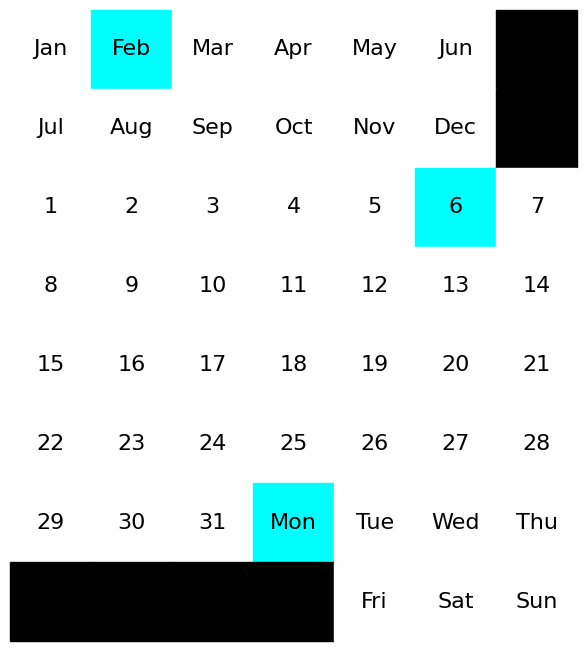

In [938]:
display(puzzle, mask)

## The Pieces

The puzzle has 10 pieces that can fill the puzzle in an incredibly large number of combinations. Similar to tetris pieces, these are read from a .txt file as well. Each shape can also be rotates 4 ways and reflected, making a total of 8 uniquie variants for each shape. 

Of course, some shapes are symmetric which decreases the variants to 4 or even 2 in some cases.

In [939]:
# Read shapes
with open('shapes.txt', 'r') as f:
    shapes = f.read()
shapes = shapes.split("\n\n")
shapes = [[list(map(int, s.split(" "))) for s in shape.split("\n")] for shape in shapes]

In [940]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Create variations of the shapes
new_shapes = []
for i, shape in enumerate(shapes):
    check = np.array(shape)
    new_shape = np.where(check == 1, i+2, 0)
    flipped_shape = np.fliplr(new_shape)
    t_shapes = []
    for i in range(4):
        new_shape = np.rot90(new_shape)
        unique = True
        for check in t_shapes:
            if np.array_equal(new_shape, check):
                unique = False
                break
        if unique:
            t_shapes.append(new_shape)
        flipped_shape = np.rot90(flipped_shape)
        unique = True
        for check in t_shapes:
            if np.array_equal(flipped_shape, check):
                unique = False
                break
        if unique:
            t_shapes.append(flipped_shape)
    new_shapes.append(t_shapes)

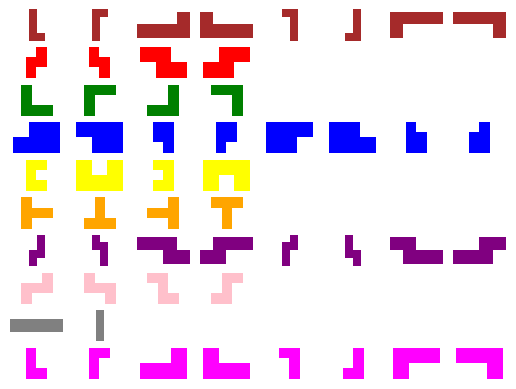

In [941]:
# Display shapes
def display_shapes(shapes):
    _, axs = plt.subplots(10, 8)
    cmap = ListedColormap(colors)
    printed = []
    for i, pieces in enumerate(shapes):
        for j, piece in enumerate(pieces):
                axs[i, j].axis("off")
                axs[i, j].imshow(piece, cmap=cmap, vmin=0, vmax=12)
                printed.append((i, j))

    for i in range(10):
        for j in range(8):
            if (i, j) in printed:
                continue
            axs[i, j].axis("off")
    plt.show()

display_shapes(new_shapes)

## Placing Pieces

Next, we define the method to place a piece on a board. Initially, this method was written to simply check if all the non-empty squares of a piece can be places an empty square in the puzzle given an x and y co-ordinate indicating the top-left of the piece. 

However, this turned out to be a problem which I will explain later on. The current version of this function checks from left-to-right and top-to-bottom first. Then it check right-to-left and top-to-bottom, and so on, to check if the piece can be placed in the puzzle.

In [943]:
def place_piece(mask, piece, y, x):
    # Check if piece can be placed
    def inner_place(y=y, x=x, y_remove=0, x_remove=0):
        try:
            if x_remove:
                x = x - len(piece) + 1
            if y_remove:
                y = y - len(piece[0]) + 1
            if(x < 0):
                return False
            if(y < 0):
                return False
            for i in range(len(piece)):
                for j in range(len(piece[0])):
                    if piece[i][j] != 0:
                        if mask[x + i][y + j] != 1:
                            return False
            # Place piece
            for i in range(len(piece)):
                for j in range(len(piece[0])):
                    if piece[i][j] != 0:
                        mask[x + i][y + j] = piece[i][j]
        except IndexError:
            return False
        return mask
    result_mask = inner_place()
    if result_mask is not False:
        return result_mask
    result_mask = inner_place(y_remove=1)
    if result_mask is not False:
        return result_mask
    result_mask = inner_place(x_remove=1)
    if result_mask is not False:
        return result_mask
    result_mask = inner_place(x_remove=1, y_remove=1)
    if result_mask is not False:
        return result_mask
    return False

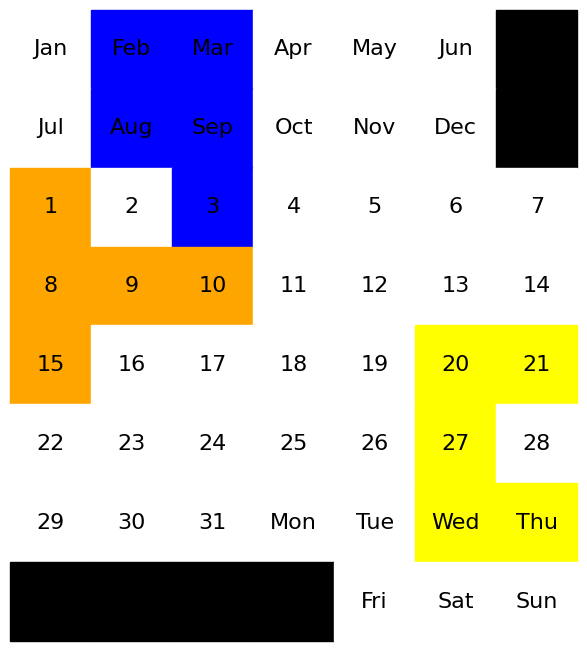

In [944]:
# Test placing a piece
import copy

test_mask = [[0 if word == "-" else 1 for word in line] for line in puzzle]
new_mask = place_piece(copy.deepcopy(test_mask), new_shapes[3][2], 1, 0)
new_mask = place_piece(copy.deepcopy(new_mask), new_shapes[4][0], 5, 4)
new_mask = place_piece(copy.deepcopy(new_mask), new_shapes[5][0], 2, 2)

display(puzzle, new_mask)

## Connected Components

As described by Wikipedia, `a component of an undirected graph is a connected subgraph that is not part of any larger connected subgraph. The components of any graph partition its vertices into disjoint sets, and are the induced subgraphs of those sets. A graph that is itself connected has exactly one component, consisting of the whole graph. Components are sometimes called connected components.`

That's a bit of a mouthful. In simple terms, in the image above this, there are 4 connected components. `(Jan, Jul)`, `(28)`, `(2)` and the rest of the puzzle. Basically, a connected component is an isolated part of the larger graph. In this puzzle's case, we can consider it to be a graph with each square representing a node and a bi-directional edge between a square and each of it's 4 neighbors. 

Connected components are a big part of the optimization explained further on.

In [945]:
def find_connected(mask):
    visited = set()
    unvisited = set([(x, y) for x in range(len(mask)) for y in range(len(mask[0]))])
    def connected_components(mask, x, y, check, components):
        if (x, y) in visited:
            return components
        if mask[x][y] != check:
            return components
        components.append((x, y))
        visited.add((x, y))
        if x > 0:
            connected_components(mask, x-1, y, check, components)
        if x < len(mask)-1:
            connected_components(mask, x+1, y, check, components)
        if y > 0:
            connected_components(mask, x, y-1, check, components)
        if y < len(mask[0])-1:
            connected_components(mask, x, y+1, check, components)
        return components
    con_lens = []
    for uv in unvisited:
        connected = connected_components(mask, uv[0], uv[1], 1, [])
        if not connected:
            continue
        con_lens.append(len(connected))
        unvisited = unvisited - visited
    if not con_lens:
        return 0
    return min(con_lens)    

In [946]:
find_connected(new_mask)

1

## The Solution

### **Iteration #1: Brute Force**

So, the first obvious approach is brute force using DFS. We can use DFS since we are using an unweighted graph where we want any solution. There are no solutions which are better than others. This also allows us to have a fixed memory size. 

Starting off, we iterate over the x co-ordinate, then the y co-ordinate. Now we have 10 pieces, with a total of 54 variants. We iterate over these, placing a piece and recursively calling the DFS function with a new mask and one less piece in the list. 

The exit condition is that the remaining pieces list is empty. Obviously, the search space is too large since we have 3 nested loops. This method does not work in a reasonable time.

### **Iteration #2: Connected Components**

We discussed connected components previously. Here's where we use it. After placing a piece, we find the smallest connected component in the puzzle. From our pieces, we can see that no piece is smaller than 4 squares. So, if we have any connected component with less than 4 pieces, that hole in the puzzle cannot be filled with any piece. 

Connected components runs in O(n) time using DFS. That might seem slow, but it prunes the search tree enough to make up for it. Adding connected components speeds up the code by `10x`. 

### **Iteration #3: An Obvious Missed Optimization**

After adding connected components, the code was still too slow to give me a solution. I could not figure out why it wasn't working fast enough. And then I saw it. Something obvious that I had missed. 

Initially, the x and y co-ordinate loops were nested inside. This meant that a piece was tried on every co-ordinate before it was changed. Switching this out, moving the co-ordinate loops outside revealed the optimization. Now, every piece is tried on a co-ordinate before moving on. Now, if we try every piece, and none of the variants fits in a co-ordinate, we backtrack. Since no piece can fit in that square, it will always be empty, making the solution so far wrong. 

Adding this also revealed the need to change the `place_piece` function to check if a piece can fit in 4 different directions. This is due to the fact that we end the co-ordinate loop if the co-ordinate has a value that is not `1`. This causes an issue with pieces that are empty in the top-left position. 

This approach is fast enough to solve any date on the puzzle within 2 seconds. 

In [947]:
def get_solution(puzzle, mask, pieces):
    masks = []
    def dfs(state):
        nonlocal masks
        masks.append(state['mask'])
        remaining_pieces = state['pieces']
        for x in range(len(state['mask'])):
            for y in range(len(state['mask'][x])):
                if state['mask'][x][y] != 1:
                    continue
                prior_length = len(remaining_pieces)
                for piece in remaining_pieces:
                    variant_pieces = new_shapes[piece]
                    for variant in variant_pieces:
                        new_state = copy.deepcopy(state)
                        new_mask = place_piece(new_state['mask'], variant, y, x)
                        if not new_mask:
                            continue
                        if(len(new_state['pieces']) == 1):
                            display(puzzle, new_mask)
                            masks.append(new_mask)
                            return True
                        min_con = find_connected(new_mask)
                        if min_con < 4:
                            continue
                        new_state['mask'] = new_mask
                        new_state['pieces'].remove(piece)
                        new_state['depth'] += 1
                        if(dfs(new_state)):
                            return True
                if len(remaining_pieces) == prior_length:
                    return False
        return False
    
    state = {
        'mask': mask,
        'pieces': pieces,
        'depth': 0
    }
    dfs(state)
    return masks

### Solution for 6th February, 2023

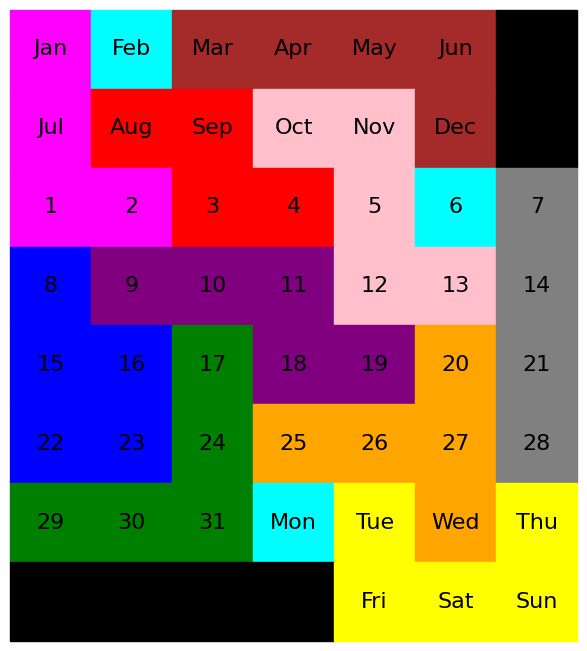

In [948]:
import random

pieces = list(range(10))
random.shuffle(pieces)
frames = get_solution(puzzle, mask, pieces)
total_frames = len(frames)
max_frames = 300
if total_frames > max_frames:
    skip = total_frames // max_frames
    final_frames = frames[::skip]
frames.extend([frames[-1]] * 20)
final_frames = [frames[0]] * 10
final_frames.extend(frames)

## Extra: Animating the solution

Here's a bit of extra code that animates the entire solution using `matplotlib`

In [949]:
from matplotlib import animation
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def animate_fast(folder, frames, puzzle, width):
    fig = plt.figure(figsize=(width, width))
    ax = plt.subplot()
    fig.patch.set_visible(False)
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
    table = ax.table(puzzle, cellLoc='center', bbox=[0, 0, 1, 1])
    ax.set_axis_off()
    table.auto_set_font_size(False)
    table.set_fontsize(22)
    def update_img(frame):
        plot = get_plot(puzzle, frame, fig, ax, table)
        return plot[0].tables
    my_anim = animation.FuncAnimation(fig, update_img, frames, blit=True)
    my_anim.save(f'{folder}.gif')
    return my_anim


MovieWriter ffmpeg unavailable; using Pillow instead.


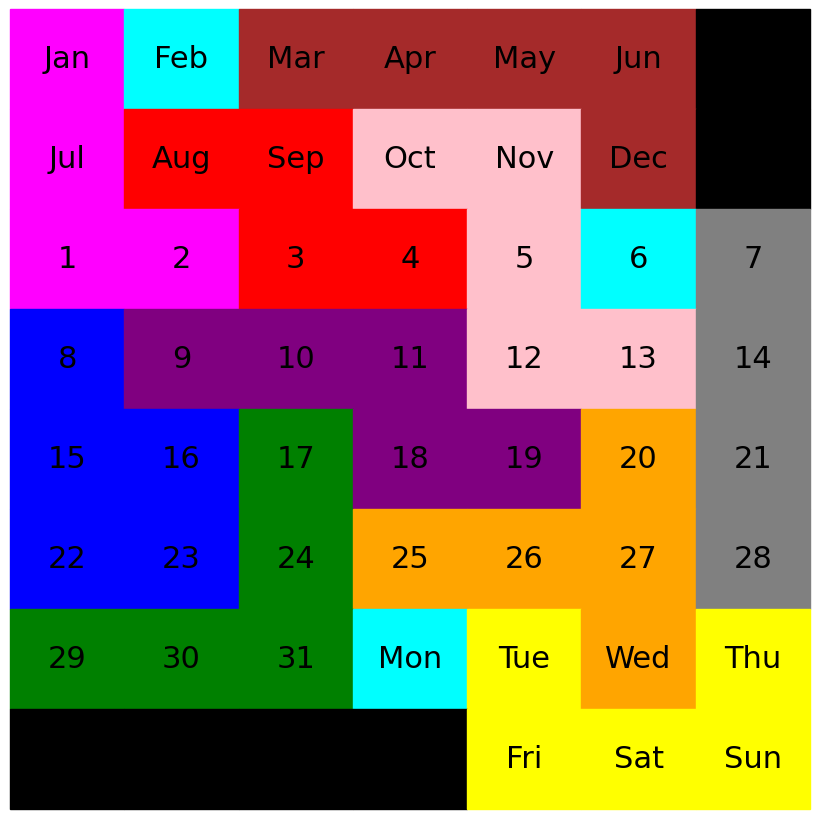

In [950]:
animate_fast('test', final_frames, puzzle, 8)

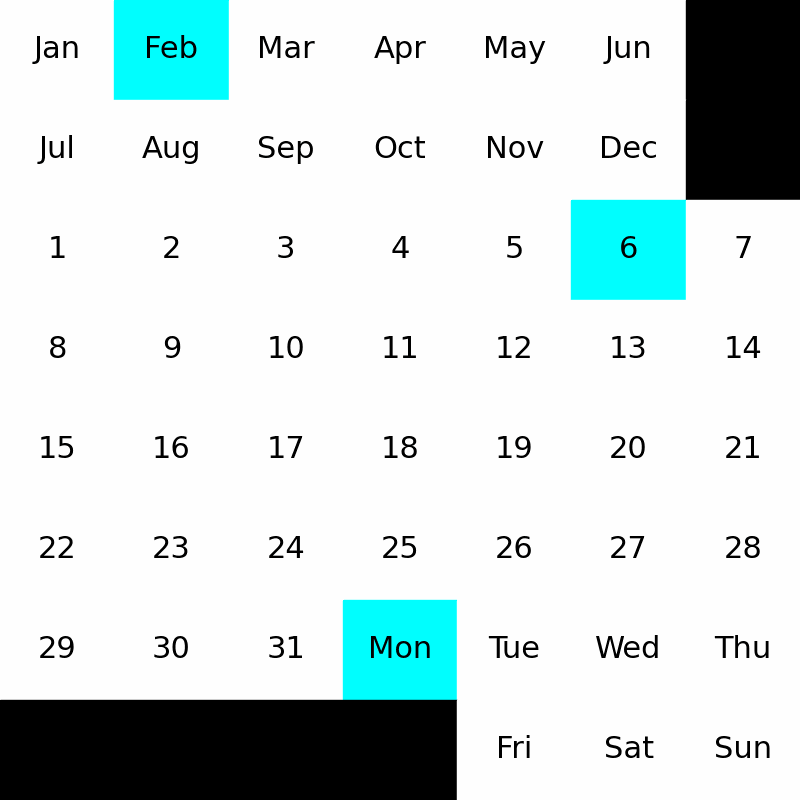

In [951]:
from IPython import display

display.display(display.Image("test.gif"))